## Exploratory Data Analysis

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [110]:
concrete = pd.read_csv('data/concrete.csv')
co2 = pd.read_csv('data/co2.csv')

concrete['co2_lower'] = sum([concrete[col] * co2.loc[co2.ingredient == col, 'lower_bound'].values[0] for col in concrete.columns[:7]])
concrete['co2_upper'] = sum([concrete[col] * co2.loc[co2.ingredient == col, 'upper_bound'].values[0] for col in concrete.columns[:7]])
concrete.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cement        1030 non-null   float64
 1   slag          1030 non-null   float64
 2   ash           1030 non-null   float64
 3   water         1030 non-null   float64
 4   superplastic  1030 non-null   float64
 5   coarseagg     1030 non-null   float64
 6   fineagg       1030 non-null   float64
 7   age           1030 non-null   int64  
 8   strength      1030 non-null   float64
 9   co2_lower     1030 non-null   float64
 10  co2_upper     1030 non-null   float64
dtypes: float64(10), int64(1)
memory usage: 88.6 KB


In [111]:
concrete_train, concrete_test = train_test_split(concrete,
                                                 shuffle=True,
                                                 random_state=48)

### Basic plotting

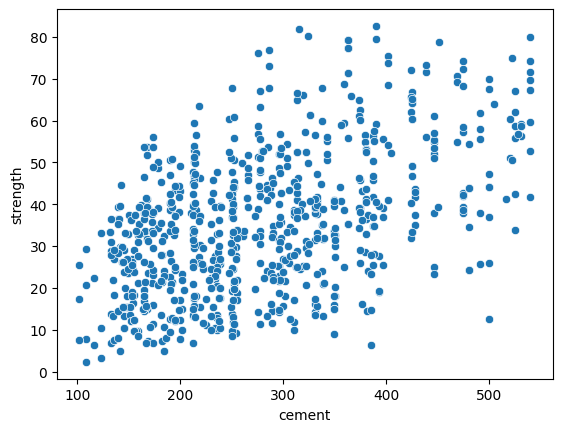

In [112]:
sns.scatterplot(data=concrete_train,
                x='cement',
                y='strength')

plt.show()

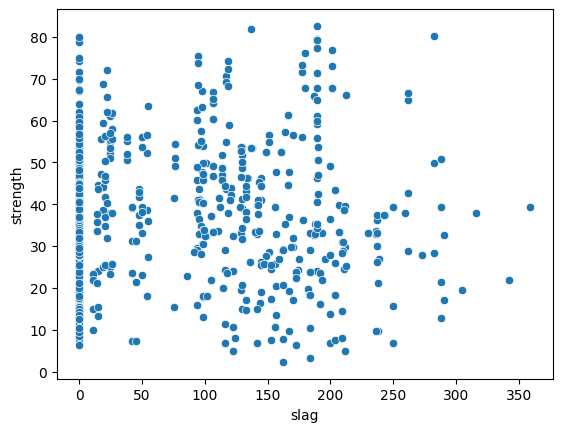

In [113]:
sns.scatterplot(data=concrete_train,
                x='slag',
                y='strength')

plt.show()

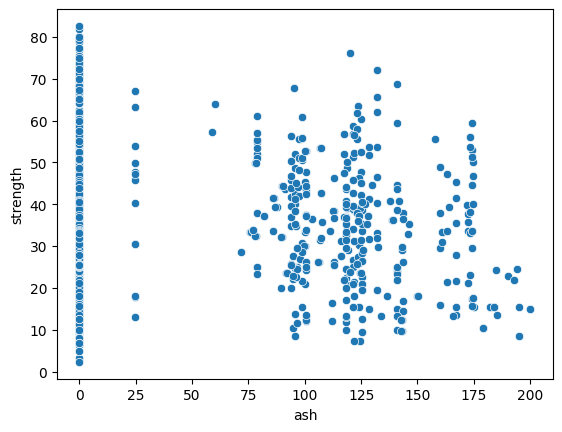

In [114]:
sns.scatterplot(data=concrete_train,
                x='ash',
                y='strength')

plt.show()

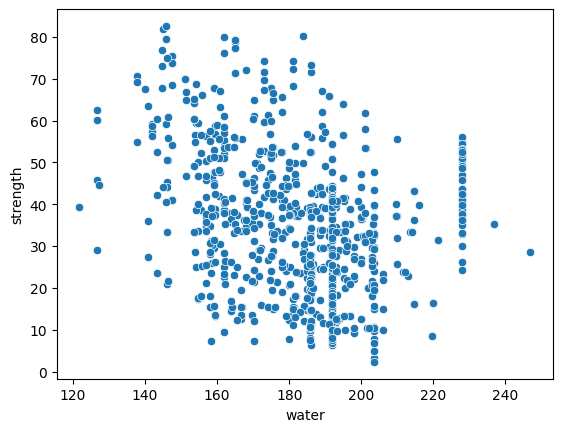

In [115]:
sns.scatterplot(data=concrete_train,
                x='water',
                y='strength')

plt.show()

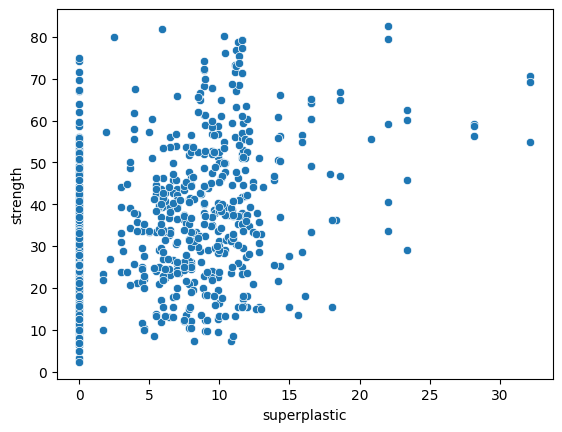

In [116]:
sns.scatterplot(data=concrete_train,
                x='superplastic',
                y='strength')

plt.show()

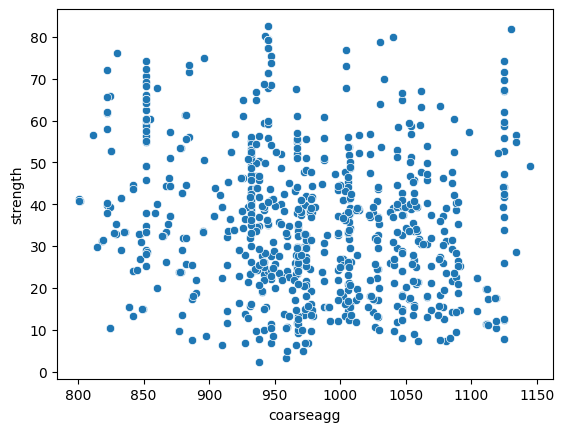

In [117]:
sns.scatterplot(data=concrete_train,
                x='coarseagg',
                y='strength')

plt.show()

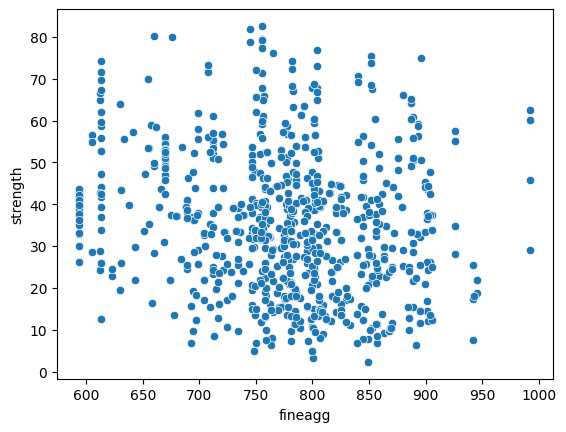

In [118]:
sns.scatterplot(data=concrete_train,
                x='fineagg',
                y='strength')

plt.show()

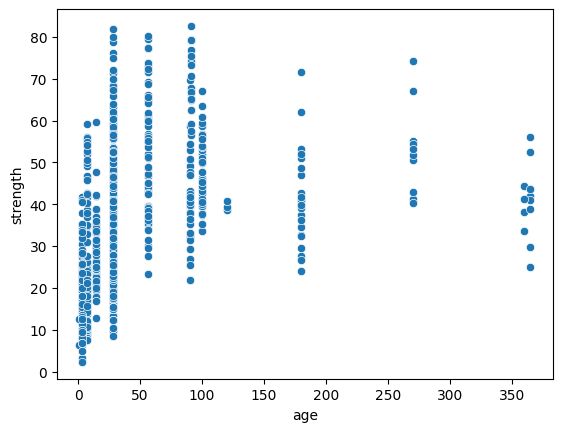

In [119]:
sns.scatterplot(data=concrete_train,
                x='age',
                y='strength')

plt.show()

### Exponential model for age

We know from the literature that the strength of concrete is roughly M - Ce^(-kt), so we try to find the best fit

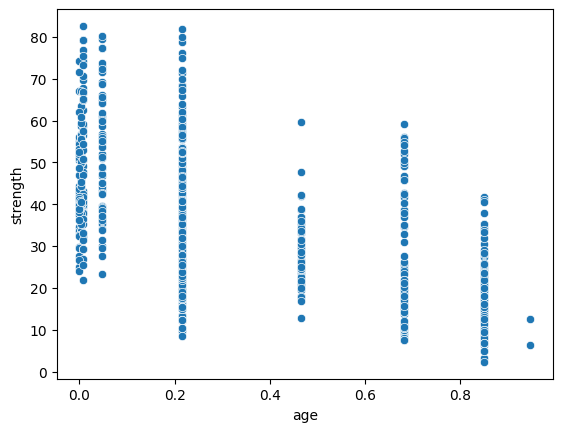

In [120]:
sns.scatterplot(data=concrete_train,
                x=np.exp(-20 * concrete_train['age']/365),
                y='strength')

plt.show()

In [68]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

In [121]:
# for future use, this function gets mean squared error without constantly copy-pasting

def get_slr_mses(data, features_list, y, k=5, rs=97):
    # data is the dataframe
    # features_list is a list of all lists of features we wish to compare
    # eg [[], ['feature1'], ['feature1', 'feature2, 'feature5']]
    # if one list is [], then we make a baseline prediction
    # y is the y feature we are predicting
    # k is the number of cross-validation splits
    # rs is the random_state for kfold
    kfold = KFold(k,
              shuffle=True,
              random_state=rs)
    mses=np.zeros((k, len(features_list)))

    i = 0
    # cross-validation
    for train_index, test_index in kfold.split(data):
        data_tt = data.iloc[train_index]
        data_ho = data.iloc[test_index]

        j = 0
        for features in features_list:
            if features == []:
                # baseline prediction
                pred = data_tt[y].values.mean() * np.ones(len(data_ho))
            else:
                reg = LinearRegression(copy_X=True)
                reg.fit(data_tt[features], data_tt[y])
                pred = reg.predict(data_ho[features])
            
            mses[i, j] = mean_squared_error(y_true=data_ho[y],
                                            y_pred=pred)
            j += 1
        
        i += 1

    return np.mean(mses, axis=0)



In [122]:
# test
features_list = [[], ['cement'], ['age']]
get_slr_mses(concrete_train, features_list, 'strength')

array([290.01606594, 214.89707022, 257.36184867])

In [123]:
for factor in np.arange(.01, .1, .01):
    concrete_train['exp_age'] = np.exp(-factor * concrete_train['age'])
    print(factor, get_slr_mses(concrete_train, [['exp_age']], 'strength')[0])

0.01 216.36840486043883
0.02 196.67122478325172
0.03 188.94189486235805
0.04 187.27882033542122
0.05 188.63115047729818
0.060000000000000005 191.26390996061286
0.06999999999999999 194.25578567825374
0.08 197.1699958645198
0.09 199.83124703217874


In [124]:
exp_age_mses = []
for factor in np.arange(.03, .05, .001):
    concrete_train['exp_age'] = np.exp(-factor * concrete_train['age'])
    exp_age_mses.append(get_slr_mses(concrete_train, [['exp_age']], 'strength')[0])

print(np.arange(.025, .55, .001)[np.argmin(exp_age_mses)], np.min(exp_age_mses))

0.03400000000000001 187.27159305149067


In [125]:
concrete_train['exp_age'] = np.exp(-.34 * concrete_train['age'])

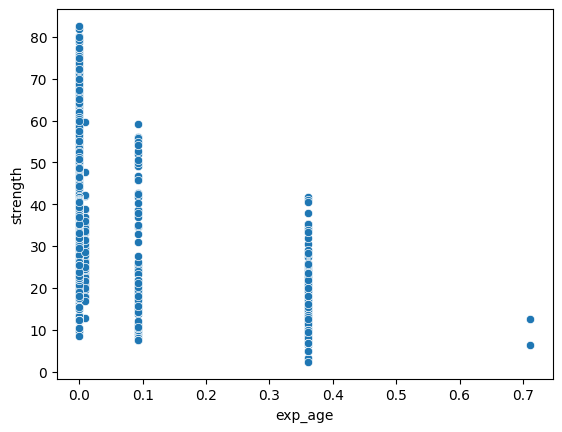

In [126]:
sns.scatterplot(data=concrete_train,
                x='exp_age',
                y='strength')

plt.show()

In [127]:
# This function was modified from stackexchange user hughdbrown 
# at this link, 
# https://stackoverflow.com/questions/1482308/how-to-get-all-subsets-of-a-set-powerset

# This returns the power set of a set minus the empty set
def powerset(s):
    power_set = []
    x = len(s)
    for i in range(1 << x):
        power_set.append([s[j] for j in range(x) if (i & (1 << j))])
        
    return power_set[1:]

In [135]:
all_features = [[]] + powerset(['cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg',
       'fineagg', 'exp_age'])

In [136]:
len(all_features)

256

In [137]:
all_mses = get_slr_mses(concrete_train, all_features, 'strength')

In [138]:
print(all_features[np.argmin(all_mses)], np.min(all_mses))

['cement', 'slag', 'ash', 'water', 'coarseagg', 'fineagg', 'exp_age'] 83.52477596057885


This is a great start, although it is worth trying other models. Since there is a high variance, we should try to make a window